# Heterogeneous Graphs & Knowledge Graphs - Hands-On Tutorial
## Graduate Course in Graph Machine Learning

**Learning Objectives:**
1. Understand heterogeneous graph structures
2. Implement R-GCN from scratch and with PyTorch Geometric
3. Apply to real-world biomedical knowledge graph
4. Visualize and interpret results

**Reference:** Hamilton, W.L. Graph Representation Learning (GRL Book), Chapters 1, 4, 5

## Setup and Installation

In [2]:
# Install required packages
%pip install torch torchvision torchaudio --quiet
%pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric --quiet
%pip install networkx matplotlib seaborn scikit-learn pandas --quiet

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv, GCNConv, Linear
import torch_geometric.transforms as T
from torch_geometric.utils import negative_sampling

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, average_precision_score

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Note: you may need to restart the kernel to use updated packages.
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [23 lines of output]
      Traceback (most recent call last):
        File "/Users/harunpirim/Documents/GitHub/graphdataA.github.io/graph-data-science-course/.venv/lib/python3.13/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 389, in <module>
          main()
          ~~~~^^
        File "/Users/harunpirim/Documents/GitHub/graphdataA.github.io/graph-data-science-course/.venv/lib/python3.13/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 373, in main
          json_out["return_val"] = hook(**hook_input["kwargs"])
                                   ~~~~^^^^^^^^^^^^^^^^^^^^^^^^
        File "/Users/harunpirim/Documents/GitHub/graphdataA.github.io/graph-data-science-course/.venv/lib/python3.13/site-packages/pip/_vendor/pyproject_hooks/_in_p

## Part 1: Understanding Heterogeneous Graphs

### 1.1 Creating a Simple Heterogeneous Graph

In [3]:
def create_simple_hetero_example():
    """
    Create a simple heterogeneous graph:
    - 3 drugs, 2 diseases, 4 proteins
    - Relations: treats, causes, binds, interacts
    """
    data = HeteroData()
    
    # Node features (for visualization, we use simple features)
    data['drug'].x = torch.eye(3)  # One-hot encoding for drugs
    data['disease'].x = torch.eye(2)  # One-hot encoding for diseases
    data['protein'].x = torch.eye(4)  # One-hot encoding for proteins
    
    # Define edges
    # Drug treats Disease
    data['drug', 'treats', 'disease'].edge_index = torch.tensor([
        [0, 1, 2],  # Drug 0, 1, 2
        [0, 1, 0]   # treat Disease 0, 1, 0
    ], dtype=torch.long)
    
    # Drug binds Protein
    data['drug', 'binds', 'protein'].edge_index = torch.tensor([
        [0, 1, 2],  # Drug 0, 1, 2
        [0, 1, 2]   # bind to Protein 0, 1, 2
    ], dtype=torch.long)
    
    # Protein interacts with Protein
    data['protein', 'interacts', 'protein'].edge_index = torch.tensor([
        [0, 1, 2, 3],  # Protein 0, 1, 2, 3
        [1, 2, 3, 0]   # interact with Protein 1, 2, 3, 0
    ], dtype=torch.long)
    
    return data

# Create example
simple_data = create_simple_hetero_example()
print(simple_data)
print("\nNode types:", simple_data.node_types)
print("Edge types:", simple_data.edge_types)
print("\nMetadata:", simple_data.metadata())

HeteroData(
  drug={ x=[3, 3] },
  disease={ x=[2, 2] },
  protein={ x=[4, 4] },
  (drug, treats, disease)={ edge_index=[2, 3] },
  (drug, binds, protein)={ edge_index=[2, 3] },
  (protein, interacts, protein)={ edge_index=[2, 4] }
)

Node types: ['drug', 'disease', 'protein']
Edge types: [('drug', 'treats', 'disease'), ('drug', 'binds', 'protein'), ('protein', 'interacts', 'protein')]

Metadata: (['drug', 'disease', 'protein'], [('drug', 'treats', 'disease'), ('drug', 'binds', 'protein'), ('protein', 'interacts', 'protein')])


### 1.2 Visualizing Heterogeneous Graphs

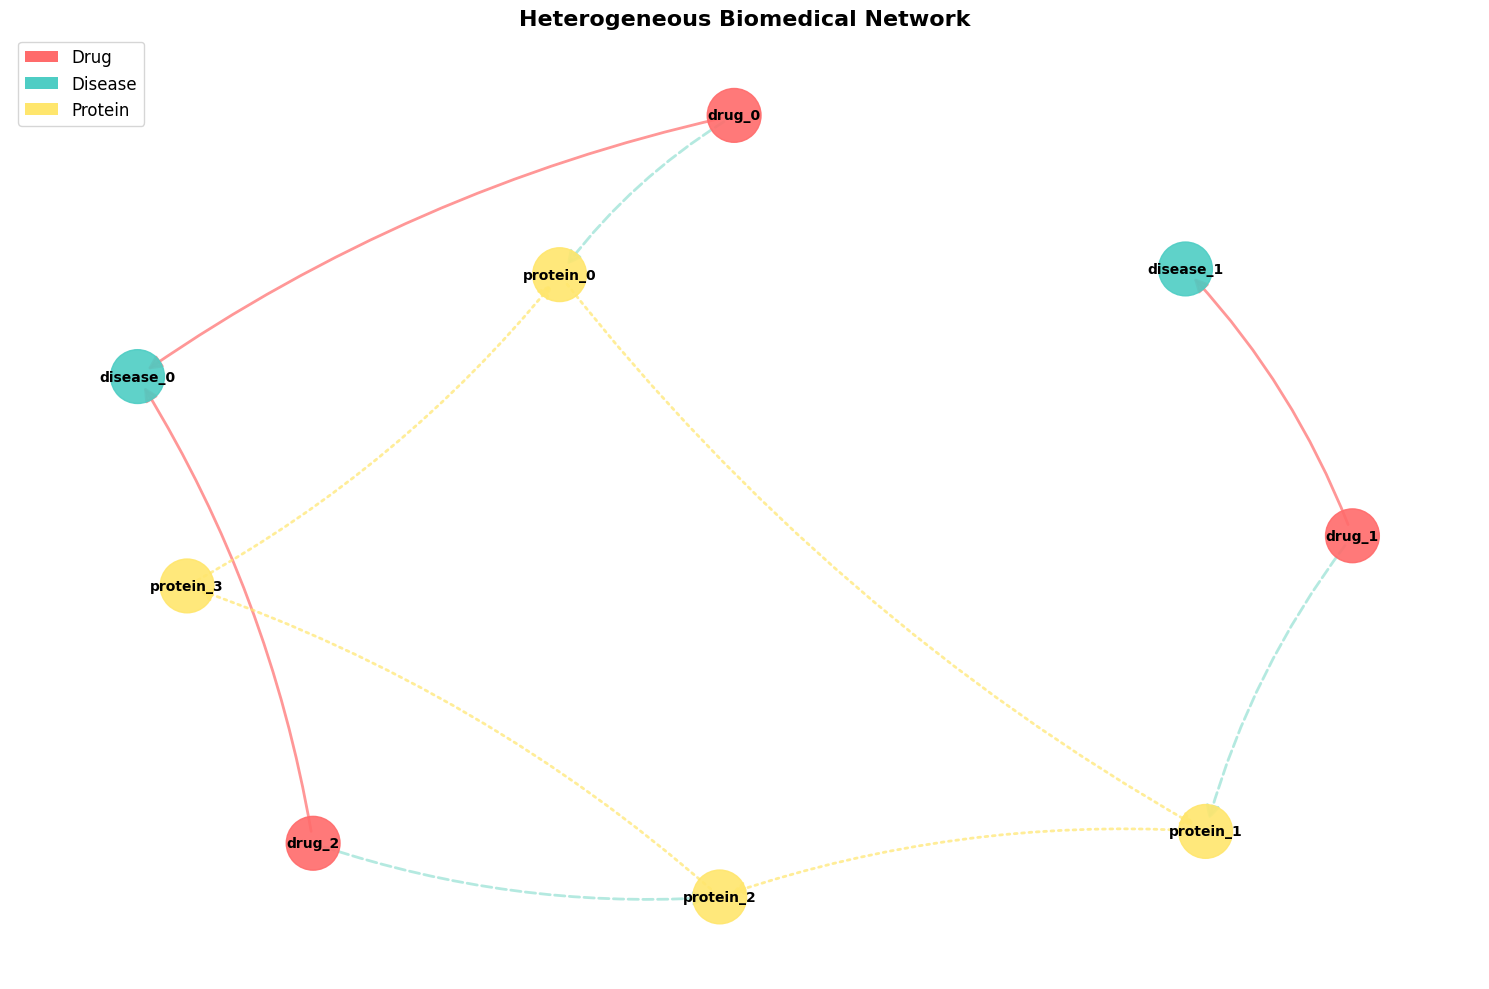

In [4]:
def visualize_hetero_graph(data):
    """
    Visualize heterogeneous graph using NetworkX
    Different colors for different node types
    Different edge styles for different relation types
    """
    G = nx.MultiDiGraph()
    
    # Color map for node types
    node_colors = {
        'drug': '#FF6B6B',
        'disease': '#4ECDC4',
        'protein': '#FFE66D'
    }
    
    # Edge styles for relation types
    edge_styles = {
        'treats': {'style': 'solid', 'color': '#FF6B6B'},
        'binds': {'style': 'dashed', 'color': '#95E1D3'},
        'interacts': {'style': 'dotted', 'color': '#FFE66D'}
    }
    
    # Add nodes with type prefix
    node_list = []
    colors = []
    
    offset = 0
    node_map = {}
    
    for node_type in data.node_types:
        num_nodes = data[node_type].x.size(0)
        for i in range(num_nodes):
            node_id = f"{node_type}_{i}"
            node_map[(node_type, i)] = node_id
            G.add_node(node_id, node_type=node_type)
            node_list.append(node_id)
            colors.append(node_colors[node_type])
    
    # Add edges
    for edge_type in data.edge_types:
        src_type, relation, dst_type = edge_type
        edge_index = data[edge_type].edge_index
        
        for i in range(edge_index.size(1)):
            src = node_map[(src_type, edge_index[0, i].item())]
            dst = node_map[(dst_type, edge_index[1, i].item())]
            G.add_edge(src, dst, relation=relation)
    
    # Layout
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_list, node_color=colors, 
                          node_size=1500, alpha=0.9)
    
    # Draw edges by relation type
    for relation, style in edge_styles.items():
        edges = [(u, v) for u, v, d in G.edges(data=True) 
                if d.get('relation') == relation]
        if edges:
            nx.draw_networkx_edges(G, pos, edges, 
                                  style=style['style'],
                                  edge_color=style['color'],
                                  width=2, alpha=0.7,
                                  arrows=True, arrowsize=20,
                                  connectionstyle='arc3,rad=0.1')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=node_colors['drug'], label='Drug'),
        Patch(facecolor=node_colors['disease'], label='Disease'),
        Patch(facecolor=node_colors['protein'], label='Protein')
    ]
    plt.legend(handles=legend_elements, loc='upper left', fontsize=12)
    
    plt.title('Heterogeneous Biomedical Network', fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_hetero_graph(simple_data)

## Part 2: Creating a Realistic Biomedical Knowledge Graph

In [5]:
def create_biomedical_kg(num_drugs=50, num_diseases=30, num_proteins=100,
                        edge_density=0.1, seed=42):
    """
    Create a synthetic biomedical knowledge graph
    
    Node types:
    - Drug: pharmaceutical compounds
    - Disease: medical conditions
    - Protein: biological proteins
    
    Edge types:
    - (Drug, treats, Disease): Drug treats Disease
    - (Drug, binds, Protein): Drug binds to Protein
    - (Protein, interacts, Protein): Protein-Protein interactions
    - (Protein, associated, Disease): Protein associated with Disease
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    data = HeteroData()
    
    # Generate node features (random for demonstration)
    data['drug'].x = torch.randn(num_drugs, 64)
    data['disease'].x = torch.randn(num_diseases, 64)
    data['protein'].x = torch.randn(num_proteins, 64)
    
    # Generate edges with realistic patterns
    
    # 1. Drug treats Disease (sparse, ~10% of possible edges)
    num_treats = int(num_drugs * num_diseases * edge_density)
    treats_edges = torch.randint(0, num_drugs, (2, num_treats))
    treats_edges[1] = torch.randint(0, num_diseases, (num_treats,))
    data['drug', 'treats', 'disease'].edge_index = treats_edges
    
    # 2. Drug binds Protein (denser, each drug binds ~5 proteins)
    num_binds = num_drugs * 5
    binds_edges = torch.zeros(2, num_binds, dtype=torch.long)
    for i in range(num_drugs):
        targets = torch.randint(0, num_proteins, (5,))
        binds_edges[0, i*5:(i+1)*5] = i
        binds_edges[1, i*5:(i+1)*5] = targets
    data['drug', 'binds', 'protein'].edge_index = binds_edges
    
    # 3. Protein-Protein interactions (scale-free network)
    num_ppi = int(num_proteins * np.log(num_proteins) * 2)
    ppi_edges = torch.randint(0, num_proteins, (2, num_ppi))
    # Make symmetric (undirected)
    ppi_edges = torch.cat([ppi_edges, ppi_edges.flip(0)], dim=1)
    data['protein', 'interacts', 'protein'].edge_index = ppi_edges
    
    # 4. Protein associated with Disease
    num_assoc = int(num_proteins * num_diseases * edge_density * 0.5)
    assoc_edges = torch.randint(0, num_proteins, (2, num_assoc))
    assoc_edges[1] = torch.randint(0, num_diseases, (num_assoc,))
    data['protein', 'associated', 'disease'].edge_index = assoc_edges
    
    # Add reverse edges for message passing
    data['disease', 'rev_treats', 'drug'].edge_index = \
        data['drug', 'treats', 'disease'].edge_index.flip(0)
    
    data['protein', 'rev_binds', 'drug'].edge_index = \
        data['drug', 'binds', 'protein'].edge_index.flip(0)
    
    data['disease', 'rev_associated', 'protein'].edge_index = \
        data['protein', 'associated', 'disease'].edge_index.flip(0)
    
    return data

# Create knowledge graph
kg_data = create_biomedical_kg(num_drugs=50, num_diseases=30, num_proteins=100)
print(kg_data)
print("\n=== Statistics ===")
for node_type in kg_data.node_types:
    print(f"{node_type}: {kg_data[node_type].x.size(0)} nodes")

print("\n=== Edge Statistics ===")
for edge_type in kg_data.edge_types:
    num_edges = kg_data[edge_type].edge_index.size(1)
    print(f"{edge_type}: {num_edges} edges")

HeteroData(
  drug={ x=[50, 64] },
  disease={ x=[30, 64] },
  protein={ x=[100, 64] },
  (drug, treats, disease)={ edge_index=[2, 150] },
  (drug, binds, protein)={ edge_index=[2, 250] },
  (protein, interacts, protein)={ edge_index=[2, 1842] },
  (protein, associated, disease)={ edge_index=[2, 150] },
  (disease, rev_treats, drug)={ edge_index=[2, 150] },
  (protein, rev_binds, drug)={ edge_index=[2, 250] },
  (disease, rev_associated, protein)={ edge_index=[2, 150] }
)

=== Statistics ===
drug: 50 nodes
disease: 30 nodes
protein: 100 nodes

=== Edge Statistics ===
('drug', 'treats', 'disease'): 150 edges
('drug', 'binds', 'protein'): 250 edges
('protein', 'interacts', 'protein'): 1842 edges
('protein', 'associated', 'disease'): 150 edges
('disease', 'rev_treats', 'drug'): 150 edges
('protein', 'rev_binds', 'drug'): 250 edges
('disease', 'rev_associated', 'protein'): 150 edges


## Part 3: Implementing R-GCN

### 3.1 Naive R-GCN (No Parameter Sharing)

In [6]:
class NaiveRGCN(nn.Module):
    """
    Relational GCN without parameter sharing
    Each relation gets its own transformation matrix
    
    Following GRL Book Section 5.4.1:
    m_N(u) = Σ_{τ∈R} Σ_{v∈N_τ(u)} W_τ h_v / c_{u,v}
    """
    def __init__(self, metadata, hidden_channels, out_channels, num_layers=2):
        super().__init__()
        
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        
        for i in range(num_layers):
            conv_dict = {}
            
            for edge_type in metadata[1]:  # All edge types
                if i == num_layers - 1:
                    # Last layer: anything → output
                    conv_dict[edge_type] = SAGEConv((-1, -1), out_channels)
                elif i == 0:
                    # First layer (not last): input features → hidden
                    conv_dict[edge_type] = SAGEConv((-1, -1), hidden_channels)
                else:
                    # Middle layers: hidden → hidden
                    conv_dict[edge_type] = SAGEConv((-1, -1), hidden_channels)
            
            # HeteroConv aggregates across all edge types
            self.convs.append(HeteroConv(conv_dict, aggr='sum'))
    
    def forward(self, x_dict, edge_index_dict):
        for i, conv in enumerate(self.convs):
            x_dict = conv(x_dict, edge_index_dict)
            
            # ReLU activation for intermediate layers
            if i < self.num_layers - 1:
                x_dict = {key: F.relu(x) for key, x in x_dict.items()}
                x_dict = {key: F.dropout(x, p=0.5, training=self.training) 
                         for key, x in x_dict.items()}
        
        return x_dict

# Initialize model
model = NaiveRGCN(
    metadata=kg_data.metadata(),
    hidden_channels=128,
    out_channels=64,
    num_layers=2
)

print(model)

# Test forward pass first to initialize lazy parameters
with torch.no_grad():
    out = model(kg_data.x_dict, kg_data.edge_index_dict)
    print("\nOutput shapes:")
    for node_type, embeddings in out.items():
        print(f"  {node_type}: {embeddings.shape}")

# Now count parameters after they're initialized
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

NaiveRGCN(
  (convs): ModuleList(
    (0-1): 2 x HeteroConv(num_relations=7)
  )
)

Output shapes:
  disease: torch.Size([30, 64])
  protein: torch.Size([100, 64])
  drug: torch.Size([50, 64])

Total parameters: 230,720


### 3.2 R-GCN with Basis Decomposition

**Key Idea (GRL Book Eq 5.34):** Share parameters across relations using basis matrices

$$W_\tau = \sum_{i=1}^b \alpha_{i,\tau} B_i$$

This reduces parameters from $|R| \times d^2$ to $b \times d^2 + |R| \times b$

In [7]:
from torch_geometric.nn import RGCNConv

class BasisRGCN(nn.Module):
    """
    R-GCN with basis decomposition for parameter sharing
    
    Following GRL Book Section 5.4.1:
    W_τ = Σ_i α_{i,τ} B_i
    
    This dramatically reduces parameters:
    - Without basis: |R| × d²
    - With basis: b × d² + |R| × b (where b << |R|)
    """
    def __init__(self, num_nodes_dict, num_relations, hidden_channels, 
                 out_channels, num_bases=5, num_layers=2):
        super().__init__()
        
        # Note: For simplicity, we convert hetero graph to homogeneous
        # In practice, you'd use more sophisticated node type handling
        
        self.convs = nn.ModuleList()
        
        # First layer
        self.convs.append(
            RGCNConv(64, hidden_channels, num_relations, num_bases=num_bases)
        )
        
        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(
                RGCNConv(hidden_channels, hidden_channels, 
                        num_relations, num_bases=num_bases)
            )
        
        # Output layer
        self.convs.append(
            RGCNConv(hidden_channels, out_channels, 
                    num_relations, num_bases=num_bases)
        )
    
    def forward(self, x, edge_index, edge_type):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index, edge_type)
            if i < len(self.convs) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=0.5, training=self.training)
        return x

# Convert heterogeneous graph to homogeneous for RGCNConv
homo_data = kg_data.to_homogeneous()

# Create basis model
num_relations = homo_data.edge_type.max().item() + 1
basis_model = BasisRGCN(
    num_nodes_dict=None,
    num_relations=num_relations,
    hidden_channels=128,
    out_channels=64,
    num_bases=5,
    num_layers=2
)

print(basis_model)

# Test forward pass
with torch.no_grad():
    out = basis_model(homo_data.x, homo_data.edge_index, homo_data.edge_type)
    print(f"\nOutput shape: {out.shape}")

# Count parameters after initialization
print(f"\nTotal parameters: {sum(p.numel() for p in basis_model.parameters()):,}")

# Compare parameter counts
naive_params = sum(p.numel() for p in model.parameters())
basis_params = sum(p.numel() for p in basis_model.parameters())

print(f"\n=== Parameter Comparison ===")
print(f"Naive R-GCN: {naive_params:,} parameters")
print(f"Basis R-GCN: {basis_params:,} parameters")
print(f"Reduction: {(1 - basis_params/naive_params)*100:.1f}%")

BasisRGCN(
  (convs): ModuleList(
    (0): RGCNConv(64, 128, num_relations=7)
    (1): RGCNConv(128, 64, num_relations=7)
  )
)

Output shape: torch.Size([180, 64])

Total parameters: 98,566

=== Parameter Comparison ===
Naive R-GCN: 230,720 parameters
Basis R-GCN: 98,566 parameters
Reduction: 57.3%


## Part 4: Link Prediction on Knowledge Graph

**Task:** Predict missing (Drug, treats, Disease) edges

In [8]:
# Prepare data for link prediction
def prepare_link_prediction_data(data, edge_type, test_ratio=0.2, val_ratio=0.1):
    """
    Split edges into train/val/test sets for link prediction
    """
    edge_index = data[edge_type].edge_index
    num_edges = edge_index.size(1)
    
    # Random permutation
    perm = torch.randperm(num_edges)
    
    # Split indices
    test_size = int(num_edges * test_ratio)
    val_size = int(num_edges * val_ratio)
    train_size = num_edges - test_size - val_size
    
    train_idx = perm[:train_size]
    val_idx = perm[train_size:train_size + val_size]
    test_idx = perm[train_size + val_size:]
    
    # Create splits
    data[edge_type].edge_label_index = edge_index
    data[edge_type].train_idx = train_idx
    data[edge_type].val_idx = val_idx
    data[edge_type].test_idx = test_idx
    
    # Use only training edges for message passing
    train_data = data.clone()
    train_data[edge_type].edge_index = edge_index[:, train_idx]
    
    return train_data, data

# Prepare data
target_edge = ('drug', 'treats', 'disease')
train_data, full_data = prepare_link_prediction_data(kg_data, target_edge)

print(f"Total {target_edge} edges: {kg_data[target_edge].edge_index.size(1)}")
print(f"Train edges: {len(train_data[target_edge].train_idx)}")
print(f"Val edges: {len(full_data[target_edge].val_idx)}")
print(f"Test edges: {len(full_data[target_edge].test_idx)}")

Total ('drug', 'treats', 'disease') edges: 150
Train edges: 105
Val edges: 15
Test edges: 30


In [9]:
class EdgeDecoder(nn.Module):
    """
    Edge decoder for link prediction
    
    Takes embeddings of two nodes and predicts edge probability
    """
    def __init__(self, hidden_channels):
        super().__init__()
        # Simple MLP decoder
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)
    
    def forward(self, z_src, z_dst, edge_label_index):
        """
        Args:
            z_src: Source node embeddings
            z_dst: Target node embeddings  
            edge_label_index: Edges to predict [2, num_edges]
        """
        # Get embeddings for edge endpoints
        src = z_src[edge_label_index[0]]
        dst = z_dst[edge_label_index[1]]
        
        # Concatenate and predict
        z = torch.cat([src, dst], dim=-1)
        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.sigmoid()

def compute_link_pred_metrics(pred, labels):
    """
    Compute AUC and AP for link prediction
    """
    pred = pred.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    
    auc = roc_auc_score(labels, pred)
    ap = average_precision_score(labels, pred)
    
    return auc, ap

# Initialize models
encoder = NaiveRGCN(
    metadata=train_data.metadata(),
    hidden_channels=64,
    out_channels=32,
    num_layers=2
)
decoder = EdgeDecoder(hidden_channels=32)

optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=0.01
)

print("Models initialized!")

# Run a dummy forward pass to initialize lazy parameters
with torch.no_grad():
    dummy_z_dict = encoder(train_data.x_dict, train_data.edge_index_dict)
    # Create a small dummy edge for decoder
    dummy_edge = torch.tensor([[0], [0]])
    src_type, _, dst_type = target_edge
    dummy_pred = decoder(dummy_z_dict[src_type], dummy_z_dict[dst_type], dummy_edge)

# Now count parameters after they're initialized
print(f"Encoder parameters: {sum(p.numel() for p in encoder.parameters()):,}")
print(f"Decoder parameters: {sum(p.numel() for p in decoder.parameters()):,}")

Models initialized!
Encoder parameters: 86,688
Decoder parameters: 2,113


In [10]:
def train_link_prediction(encoder, decoder, data, edge_type, num_epochs=100):
    """
    Train link prediction model
    """
    src_type, _, dst_type = edge_type
    
    history = {
        'train_loss': [],
        'val_auc': [],
        'val_ap': []
    }
    
    for epoch in range(num_epochs):
        # Training
        encoder.train()
        decoder.train()
        optimizer.zero_grad()
        
        # Get node embeddings (using training edges only)
        z_dict = encoder(train_data.x_dict, train_data.edge_index_dict)
        z_src = z_dict[src_type]
        z_dst = z_dict[dst_type]
        
        # Positive edges (from training set)
        edge_index = full_data[edge_type].edge_label_index
        train_idx = full_data[edge_type].train_idx
        pos_edge_index = edge_index[:, train_idx]
        
        # Negative sampling
        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index,
            num_nodes=(z_src.size(0), z_dst.size(0)),
            num_neg_samples=pos_edge_index.size(1)
        )
        
        # Predictions
        pos_pred = decoder(z_src, z_dst, pos_edge_index)
        neg_pred = decoder(z_src, z_dst, neg_edge_index)
        
        # Loss
        pred = torch.cat([pos_pred, neg_pred]).squeeze()
        labels = torch.cat([
            torch.ones(pos_pred.size(0)),
            torch.zeros(neg_pred.size(0))
        ])
        
        loss = F.binary_cross_entropy(pred, labels)
        loss.backward()
        optimizer.step()
        
        history['train_loss'].append(loss.item())
        
        # Validation
        if epoch % 10 == 0:
            encoder.eval()
            decoder.eval()
            
            with torch.no_grad():
                z_dict = encoder(train_data.x_dict, train_data.edge_index_dict)
                z_src = z_dict[src_type]
                z_dst = z_dict[dst_type]
                
                val_idx = full_data[edge_type].val_idx
                val_pos_edge = edge_index[:, val_idx]
                
                val_neg_edge = negative_sampling(
                    edge_index=val_pos_edge,
                    num_nodes=(z_src.size(0), z_dst.size(0)),
                    num_neg_samples=val_pos_edge.size(1)
                )
                
                val_pos_pred = decoder(z_src, z_dst, val_pos_edge)
                val_neg_pred = decoder(z_src, z_dst, val_neg_edge)
                
                val_pred = torch.cat([val_pos_pred, val_neg_pred]).squeeze()
                val_labels = torch.cat([
                    torch.ones(val_pos_pred.size(0)),
                    torch.zeros(val_neg_pred.size(0))
                ])
                
                auc, ap = compute_link_pred_metrics(val_pred, val_labels)
                history['val_auc'].append(auc)
                history['val_ap'].append(ap)
                
                print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, '
                      f'Val AUC: {auc:.4f}, Val AP: {ap:.4f}')
    
    return history

# Train model
print("Training link prediction model...")
history = train_link_prediction(
    encoder, decoder, train_data, 
    edge_type=target_edge, 
    num_epochs=100
)

Training link prediction model...
Epoch 000, Loss: 0.6956, Val AUC: 0.4222, Val AP: 0.5037
Epoch 010, Loss: 0.5394, Val AUC: 0.5511, Val AP: 0.5361
Epoch 020, Loss: 0.4663, Val AUC: 0.6133, Val AP: 0.6287
Epoch 030, Loss: 0.2931, Val AUC: 0.6578, Val AP: 0.6243
Epoch 040, Loss: 0.2320, Val AUC: 0.5911, Val AP: 0.5537
Epoch 050, Loss: 0.2661, Val AUC: 0.5867, Val AP: 0.6336
Epoch 060, Loss: 0.2844, Val AUC: 0.6311, Val AP: 0.6143
Epoch 070, Loss: 0.2655, Val AUC: 0.6578, Val AP: 0.7403
Epoch 080, Loss: 0.1642, Val AUC: 0.5467, Val AP: 0.5283
Epoch 090, Loss: 0.2281, Val AUC: 0.5200, Val AP: 0.5713


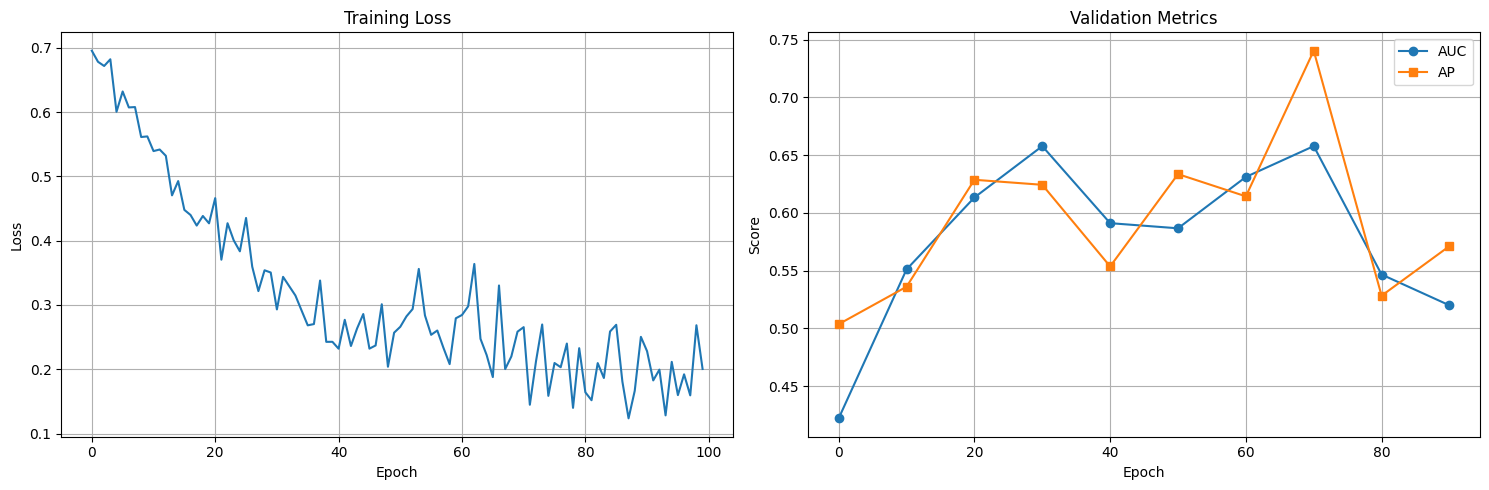


Final Validation AUC: 0.5200
Final Validation AP: 0.5713


In [11]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curve
axes[0].plot(history['train_loss'])
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True)

# Validation metrics
epochs = np.arange(0, len(history['train_loss']), 10)
axes[1].plot(epochs, history['val_auc'], label='AUC', marker='o')
axes[1].plot(epochs, history['val_ap'], label='AP', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Validation Metrics')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print(f"\nFinal Validation AUC: {history['val_auc'][-1]:.4f}")
print(f"Final Validation AP: {history['val_ap'][-1]:.4f}")

## Part 5: Evaluation and Visualization

In [12]:
# Test set evaluation
encoder.eval()
decoder.eval()

with torch.no_grad():
    # Get embeddings
    z_dict = encoder(train_data.x_dict, train_data.edge_index_dict)
    src_type, _, dst_type = target_edge
    z_src = z_dict[src_type]
    z_dst = z_dict[dst_type]
    
    # Test edges
    edge_index = full_data[target_edge].edge_label_index
    test_idx = full_data[target_edge].test_idx
    test_pos_edge = edge_index[:, test_idx]
    
    # Negative sampling for test
    test_neg_edge = negative_sampling(
        edge_index=test_pos_edge,
        num_nodes=(z_src.size(0), z_dst.size(0)),
        num_neg_samples=test_pos_edge.size(1)
    )
    
    # Predictions
    test_pos_pred = decoder(z_src, z_dst, test_pos_edge)
    test_neg_pred = decoder(z_src, z_dst, test_neg_edge)
    
    test_pred = torch.cat([test_pos_pred, test_neg_pred]).squeeze()
    test_labels = torch.cat([
        torch.ones(test_pos_pred.size(0)),
        torch.zeros(test_neg_pred.size(0))
    ])
    
    test_auc, test_ap = compute_link_pred_metrics(test_pred, test_labels)
    
    print(f"\n=== Test Set Results ===")
    print(f"AUC: {test_auc:.4f}")
    print(f"Average Precision: {test_ap:.4f}")


=== Test Set Results ===
AUC: 0.6611
Average Precision: 0.6478


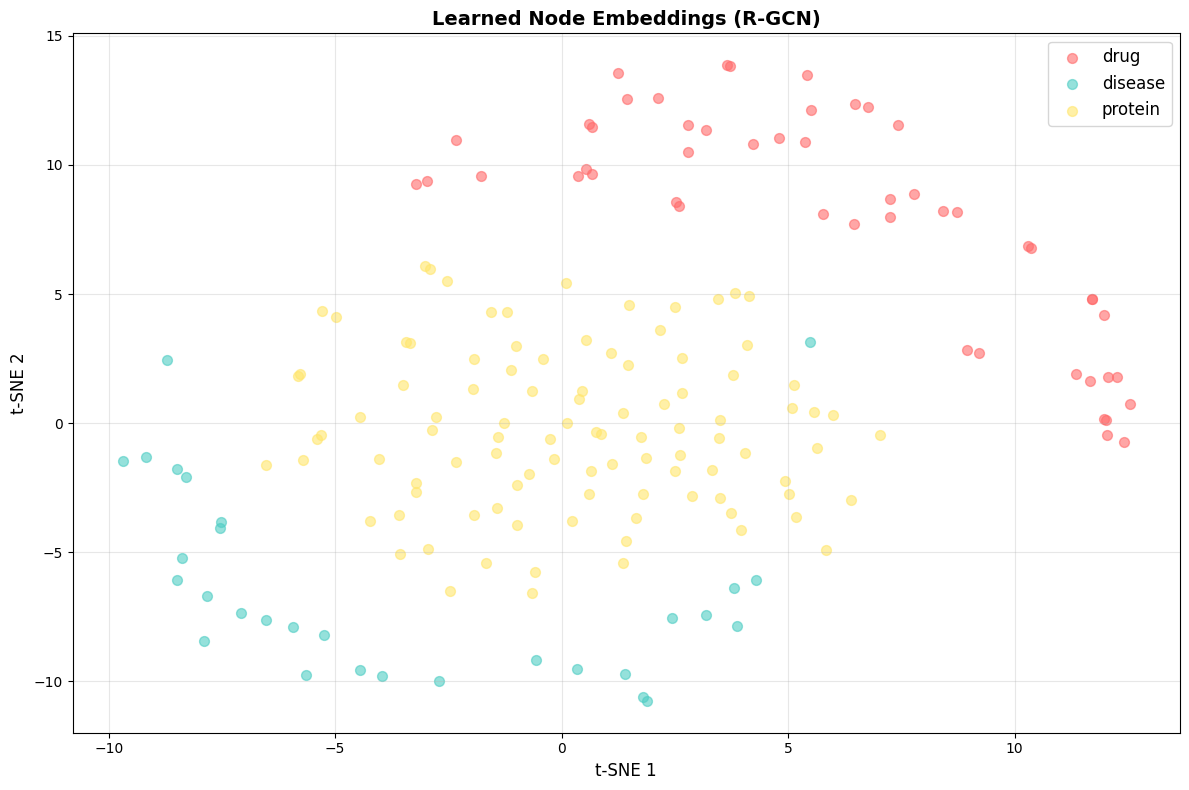

In [13]:
# Visualize embeddings with t-SNE
def visualize_embeddings(z_dict, title="Node Embeddings"):
    """
    Visualize node embeddings using t-SNE
    """
    # Collect all embeddings
    all_embeddings = []
    labels = []
    colors = []
    
    color_map = {
        'drug': '#FF6B6B',
        'disease': '#4ECDC4', 
        'protein': '#FFE66D'
    }
    
    for node_type, z in z_dict.items():
        all_embeddings.append(z.detach().cpu().numpy())
        labels.extend([node_type] * z.size(0))
        colors.extend([color_map[node_type]] * z.size(0))
    
    all_embeddings = np.vstack(all_embeddings)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_2d = tsne.fit_transform(all_embeddings)
    
    # Plot
    plt.figure(figsize=(12, 8))
    
    for node_type in color_map.keys():
        mask = np.array(labels) == node_type
        plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                   c=color_map[node_type], label=node_type,
                   alpha=0.6, s=50)
    
    plt.xlabel('t-SNE 1', fontsize=12)
    plt.ylabel('t-SNE 2', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualize learned embeddings
with torch.no_grad():
    z_dict = encoder(kg_data.x_dict, kg_data.edge_index_dict)
    visualize_embeddings(z_dict, "Learned Node Embeddings (R-GCN)")

In [14]:
# Find top-k predicted drug-disease pairs
def find_top_predictions(encoder, decoder, data, k=10):
    """
    Find top-k predicted drug-disease treatment pairs
    """
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        # Get embeddings
        z_dict = encoder(data.x_dict, data.edge_index_dict)
        z_drug = z_dict['drug']
        z_disease = z_dict['disease']
        
        # Get all possible drug-disease pairs
        num_drugs = z_drug.size(0)
        num_diseases = z_disease.size(0)
        
        # Create all pairs
        all_pairs = torch.cartesian_prod(
            torch.arange(num_drugs),
            torch.arange(num_diseases)
        ).T
        
        # Predict scores for all pairs (in batches to avoid memory issues)
        batch_size = 1000
        all_scores = []
        
        for i in range(0, all_pairs.size(1), batch_size):
            batch = all_pairs[:, i:i+batch_size]
            scores = decoder(z_drug, z_disease, batch)
            all_scores.append(scores)
        
        all_scores = torch.cat(all_scores, dim=0).squeeze()
        
        # Get top-k
        top_scores, top_indices = torch.topk(all_scores, k)
        
        # Convert to drug-disease pairs
        top_pairs = all_pairs[:, top_indices]
        
        print(f"\n=== Top {k} Predicted Drug-Disease Treatments ===")
        print(f"{'Rank':<6} {'Drug':<10} {'Disease':<10} {'Score':<10}")
        print("-" * 40)
        
        for i, (score, pair) in enumerate(zip(top_scores, top_pairs.T)):
            drug_id, disease_id = pair
            print(f"{i+1:<6} Drug_{drug_id.item():<6} Disease_{disease_id.item():<6} {score.item():.4f}")
        
        return top_pairs, top_scores

top_pairs, top_scores = find_top_predictions(encoder, decoder, kg_data, k=10)


=== Top 10 Predicted Drug-Disease Treatments ===
Rank   Drug       Disease    Score     
----------------------------------------
1      Drug_20     Disease_22     1.0000
2      Drug_44     Disease_15     0.9999
3      Drug_44     Disease_22     0.9999
4      Drug_12     Disease_15     0.9999
5      Drug_7      Disease_15     0.9998
6      Drug_21     Disease_8      0.9997
7      Drug_20     Disease_15     0.9993
8      Drug_41     Disease_22     0.9993
9      Drug_41     Disease_19     0.9991
10     Drug_37     Disease_15     0.9988


## Part 6: Analysis and Discussion

### Key Questions for Students:

Analyzing impact of network depth...

Testing depth = 1...
Depth 1: AUC = 0.6378, AP = 0.6404

Testing depth = 2...
Depth 2: AUC = 0.7311, AP = 0.6929

Testing depth = 3...
Depth 3: AUC = 0.6556, AP = 0.6539

Testing depth = 4...
Depth 4: AUC = 0.5878, AP = 0.5563


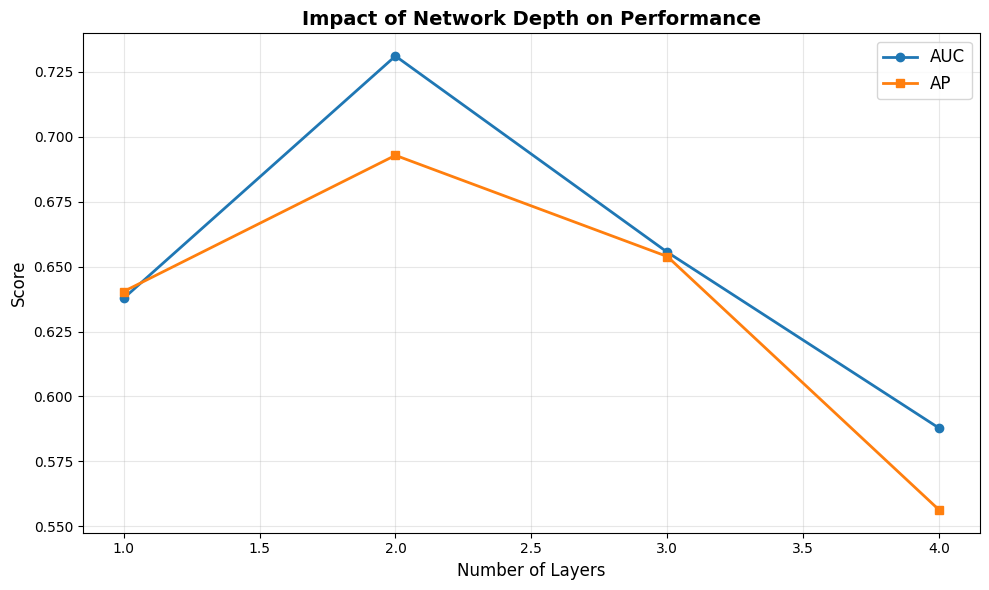

In [15]:
# Analysis: Effect of number of layers
def analyze_depth_impact():
    """
    Analyze how number of layers affects performance
    """
    depths = [1, 2, 3, 4]
    results = {'depth': [], 'auc': [], 'ap': []}
    
    for depth in depths:
        print(f"\nTesting depth = {depth}...")
        
        # Create model
        model = NaiveRGCN(
            metadata=train_data.metadata(),
            hidden_channels=64,
            out_channels=32,
            num_layers=depth
        )
        dec = EdgeDecoder(hidden_channels=32)
        
        # Quick training (20 epochs)
        opt = torch.optim.Adam(
            list(model.parameters()) + list(dec.parameters()),
            lr=0.01
        )
        
        for epoch in range(20):
            model.train()
            dec.train()
            opt.zero_grad()
            
            z_dict = model(train_data.x_dict, train_data.edge_index_dict)
            z_src = z_dict['drug']
            z_dst = z_dict['disease']
            
            edge_index = full_data[target_edge].edge_label_index
            train_idx = full_data[target_edge].train_idx
            pos_edge = edge_index[:, train_idx]
            
            neg_edge = negative_sampling(
                edge_index=pos_edge,
                num_nodes=(z_src.size(0), z_dst.size(0)),
                num_neg_samples=pos_edge.size(1)
            )
            
            pos_pred = dec(z_src, z_dst, pos_edge)
            neg_pred = dec(z_src, z_dst, neg_edge)
            
            pred = torch.cat([pos_pred, neg_pred]).squeeze()
            labels = torch.cat([
                torch.ones(pos_pred.size(0)),
                torch.zeros(neg_pred.size(0))
            ])
            
            loss = F.binary_cross_entropy(pred, labels)
            loss.backward()
            opt.step()
        
        # Evaluate
        model.eval()
        dec.eval()
        
        with torch.no_grad():
            z_dict = model(train_data.x_dict, train_data.edge_index_dict)
            z_src = z_dict['drug']
            z_dst = z_dict['disease']
            
            test_idx = full_data[target_edge].test_idx
            test_pos = edge_index[:, test_idx]
            test_neg = negative_sampling(
                edge_index=test_pos,
                num_nodes=(z_src.size(0), z_dst.size(0)),
                num_neg_samples=test_pos.size(1)
            )
            
            test_pos_pred = dec(z_src, z_dst, test_pos)
            test_neg_pred = dec(z_src, z_dst, test_neg)
            
            test_pred = torch.cat([test_pos_pred, test_neg_pred]).squeeze()
            test_labels = torch.cat([
                torch.ones(test_pos_pred.size(0)),
                torch.zeros(test_neg_pred.size(0))
            ])
            
            auc, ap = compute_link_pred_metrics(test_pred, test_labels)
            
            results['depth'].append(depth)
            results['auc'].append(auc)
            results['ap'].append(ap)
            
            print(f"Depth {depth}: AUC = {auc:.4f}, AP = {ap:.4f}")
    
    # Plot results
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    ax.plot(results['depth'], results['auc'], marker='o', label='AUC', linewidth=2)
    ax.plot(results['depth'], results['ap'], marker='s', label='AP', linewidth=2)
    ax.set_xlabel('Number of Layers', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Impact of Network Depth on Performance', fontsize=14, fontweight='bold')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results

# Run analysis (this will take a few minutes)
print("Analyzing impact of network depth...")
depth_results = analyze_depth_impact()

## Discussion Questions

1. **Why does R-GCN outperform standard GCN on heterogeneous graphs?**
   - Different relation types capture different semantics
   - Relation-specific transformations preserve type information
   - Aggregation is weighted by relation importance

2. **What are the trade-offs of basis decomposition?**
   - **Pros:** Fewer parameters, less overfitting, faster training
   - **Cons:** Reduced expressiveness, need to tune num_bases

3. **How does the number of layers affect performance?**
   - More layers = larger receptive field
   - But too many layers → over-smoothing
   - Optimal depth depends on graph diameter and task

4. **What other decoder functions could we use for link prediction?**
   - DistMult: z_h^T diag(r) z_t
   - TransE: -||z_h + r - z_t||
   - ComplEx: Re(z_h^T diag(r) z̄_t)

## Assignment

1. Implement ComplEx decoder and compare with current MLP decoder
2. Add attention mechanism to R-GCN (hint: use GATConv instead of SAGEConv)
3. Experiment with different numbers of basis matrices (1, 3, 5, 10)
4. Evaluate on all edge types, not just 'treats'
5. Try different negative sampling strategies

## Additional Resources

- **GRL Book:** Hamilton, W.L. "Graph Representation Learning"
- **R-GCN Paper:** Schlichtkrull et al. (2017)
- **PyG Documentation:** https://pytorch-geometric.readthedocs.io/
- **Knowledge Graphs:** Nickel et al. (2016) review paper